# Consulta a la API de GBIF sobre ocurrencia de quetzales en Costa Rica, periodo 2020-2021

Por: Jose Francisco Nuñez Obando y Maria Laura Pizarro

Es siguiente estudio corresponde a la asignacion de la tarea 3 del curso "Informatica para la conservación de la biodiversidad" relacionda con una practica sobre conocimientos basada en la exposicion sobre MODELADO DE NICHOS ECOLÓGICOS dictada por el Master Manuel Vargas.
Para este estudio se pone en evaluación el uso del software MAXENT  (https://biodiversityinformatics.amnh.org/open_source/maxent/) basandose en un ejercicio practico el cual se realiza utilizando datos sobre ocurrencia de la especie Quetzal (Pharomachrus mocinno) para Costa Rica en el periodo 2020-2021. Los datos se adquirieron mediante consulta a la API rest del sitio de GBIF, además del uso de datos bioclimaticos suministrados por el expositor, los cuales a su vez provienen del sitio www.worldclim.org.

El siguiente documento es creado en formato notebook con base en código Python, por lo que contiene texto narrativo, código, datos y visualizaciones, entre las cuales algunas son interactivas.

A continuación, se anotan las librerias python empleadas para mostrar el proceso de obtencion de datos, procesamiento y resultados del mismo.

In [4]:
import requests
from lxml import html, etree
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from IPython.display import Image

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
import branca.colormap as cm2
import folium
from folium.plugins import HeatMap, Fullscreen
import os
import glob
import rasterio
from rasterio.plot import show
import geopandas as gpd
import pyproj
import geojson


## Descarga de datos usando API GBIF

Se establecen los parametros de consulta y se procede a ejecutar la misma.

In [6]:
parameters = {"country": "CR",
              "year": [2020,2021],
              "limit" : 1000,
              "scientificName" : "Pharomachrus mocinno"
              }
url = "https://api.gbif.org/v1/occurrence/search?"

q_gbif = requests.request(method="get", url=url, params=parameters)

Se transforman los resultados de forma tal que unicamente se conserven las columnas "especies" y "latitud-longitud".

In [7]:
decoded_data = q_gbif.text.encode().decode('utf-8-sig')

j_gbif = json.loads(decoded_data)

jd = json_normalize(j_gbif['results'])

df = jd[['species','decimalLongitude', 'decimalLatitude']]

df.head(5)

,species,decimalLongitude,decimalLatitude
0,Pharomachrus mocinno,-84.856749,10.377864
1,Pharomachrus mocinno,-84.625545,10.384018
2,Pharomachrus mocinno,-83.453752,9.432868
3,Pharomachrus mocinno,-83.455426,9.538663
4,Pharomachrus mocinno,-83.569894,9.472196


Se revisan la cantidad de registros obtenidos.

In [8]:
df["species"].value_counts()

Pharomachrus mocinno    88
Name: species, dtype: int64

Se procede a exportar los datos a formato csv para poder utilizar estos en el software de MAXENT.

In [9]:
data_dir = r"E:/MSc_Computacion/Cursos/Informaticaparalabiodiversidad/Tareas/tarea3/"

In [10]:
df.to_csv(data_dir+'gbif_quetzal21.csv', index=None, sep=',', mode='a')

# Análisis con la herramienta MAXENT

En esta sección se hace referencia al procesamiento realizado con el software MAXENT, el cual fue desarrollado en java, asi como a los resultados obtenidos con esta.

En la parte de procesamiento, en la siguiente imagen se puede apreciar la configuración inicial del sofware con los datos suministrados, entre los que esta los datos descargados de GBIF sobre la especie Quetzal, asi como datos bioclimaticos obtenidos del sitio web worldclim.

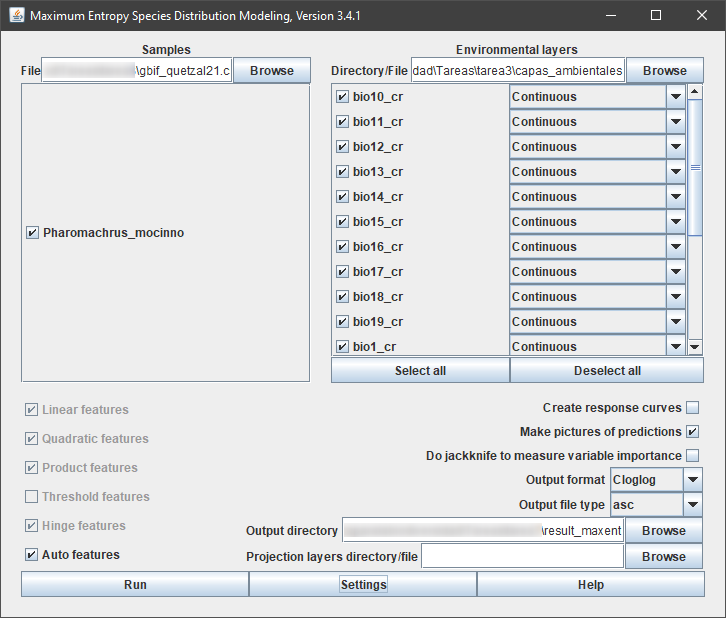

In [11]:
Image(data= data_dir+'result_maxent/menu.png', width=500, height=500)

En la configuración, únicamente se agrega un cambio en el parámetro ¨Random test percentage¨, al cual se le asigna un valor de 25.

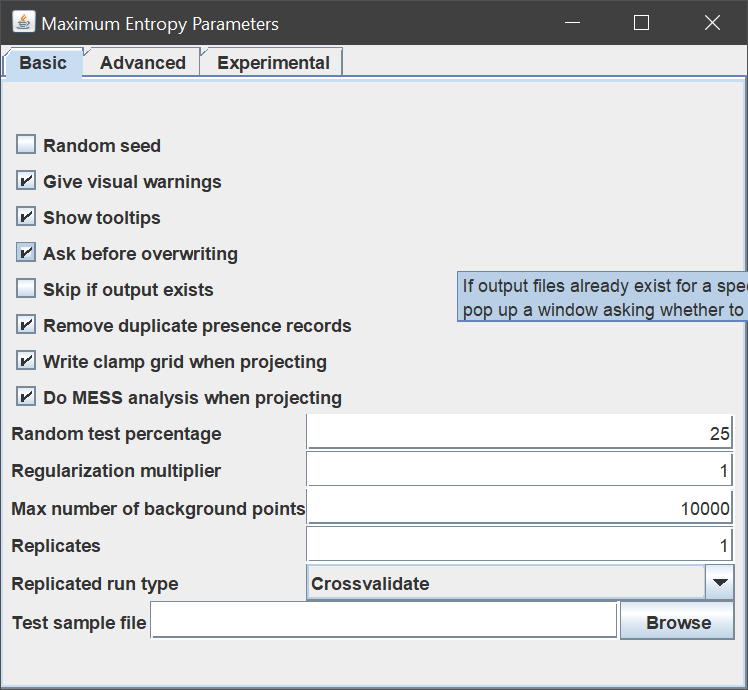

In [12]:
Image(data= data_dir+'result_maxent/settings.png', width=500, height=500)

Un aspecto importante a considerar es que representa cada uno de los datos bioclimaticos siministrados, los cuales corresponden a capas raster en cuyo caso representan las siguientes variables climáticas:

BIO1 = Annual Mean Temperature

BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))

BIO3 = Isothermality (BIO2/BIO7) (×100)

BIO4 = Temperature Seasonality (standard deviation ×100)

BIO5 = Max Temperature of Warmest Month

BIO6 = Min Temperature of Coldest Month

BIO7 = Temperature Annual Range (BIO5-BIO6)

BIO8 = Mean Temperature of Wettest Quarter

BIO9 = Mean Temperature of Driest Quarter

BIO10 = Mean Temperature of Warmest Quarter

BIO11 = Mean Temperature of Coldest Quarter

BIO12 = Annual Precipitation

BIO13 = Precipitation of Wettest Month

BIO14 = Precipitation of Driest Month

BIO15 = Precipitation Seasonality (Coefficient of Variation)

BIO16 = Precipitation of Wettest Quarter

BIO17 = Precipitation of Driest Quarter

BIO18 = Precipitation of Warmest Quarter

BIO19 = Precipitation of Coldest Quarter

(Fuente: WorldClim)

A continuación, la muestra de algunas de las capas raster utilizadas sobre datos bioclimáticos, las cuales poseen un recorte geométrico en relación con el contorno territorial del país.

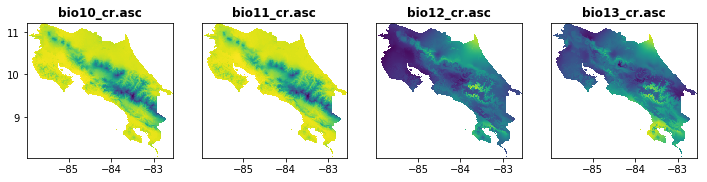

In [13]:
archivos = "bio*.asc"
q = os.path.join(data_dir+'capas_ambientales/', archivos)

dem_fps = glob.glob(q)

src_files_to_mosaic = []

# Itera sobre los archivos raster
for bio in dem_fps:
    src = rasterio.open(bio)
    src_files_to_mosaic.append(src)

# Crea algunos plot de los raster
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

show(src_files_to_mosaic[0], ax=ax1, title=os.path.basename(str(src_files_to_mosaic[0].name)))
show(src_files_to_mosaic[1], ax=ax2, title=os.path.basename(str(src_files_to_mosaic[1].name)))
show(src_files_to_mosaic[2], ax=ax3, title=os.path.basename(str(src_files_to_mosaic[2].name)))
show(src_files_to_mosaic[3], ax=ax4, title=os.path.basename(str(src_files_to_mosaic[3].name)))

# No se muestran los ejes
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

# Resultados

Los resultados obtenidos del análisis con MAXENT son los siguientes:

In [14]:
print(os.listdir(data_dir+'result_maxent/'))

['maxent.log', 'maxentResults.csv', 'menu.png', 'Pharomachrus_mocinno.asc', 'Pharomachrus_mocinno.html', 'Pharomachrus_mocinno.lambdas', 'Pharomachrus_mocinno.png', 'Pharomachrus_mocinno_explain.bat', 'Pharomachrus_mocinno_omission.csv', 'Pharomachrus_mocinno_sampleAverages.csv', 'Pharomachrus_mocinno_samplePredictions.csv', 'plots', 'settings.png']


Como se puede apreciar en la lista de archivos anterior, se obtiene un resumen de los resultados en un archivo html, ademas de imagenes en formato png y asc del mapa resultante, archivos csv con los cálculos respectivos, entre otros. 

Al consultar la tabla resultado es posible visualizar la siguiente información:

In [15]:
me_r = pd.read_csv(data_dir+'result_maxent/maxentResults.csv')   
me_r.head()

,Species,#Training samples,Regularized training gain,Unregularized training gain,Iterations,Training AUC,#Test samples,Test gain,Test AUC,AUC Standard Deviation,...,"Balance training omission, predicted area and threshold value area","Balance training omission, predicted area and threshold value training omission","Balance training omission, predicted area and threshold value test omission","Balance training omission, predicted area and threshold value binomial probability",Equate entropy of thresholded and original distributions cumulative threshold,Equate entropy of thresholded and original distributions Cloglog threshold,Equate entropy of thresholded and original distributions area,Equate entropy of thresholded and original distributions training omission,Equate entropy of thresholded and original distributions test omission,Equate entropy of thresholded and original distributions binomial probability
0,Pharomachrus_mocinno,54,1.2915,1.7516,500,0.9258,17,1.3953,0.9046,0.0302,...,0.4654,0.0185,0.0588,0.000046,10.16,0.1569,0.2845,0.0556,0.0588,2.294000e-08


Otro de los resultados que nos aporta el calculo con la herramienta MAXENT es el de la omisión de pruebas y entrenamiento sobre el área pronosticada la cual varían con la elección del umbral acumulativo. El "25" que se ingreso para el “porcentaje de prueba aleatorio” le dijo al programa que separara al azar el 25% de los registros de muestra para la prueba. Esto permite que el programa realice un análisis estadístico simple. De este modo, gran parte del análisis hizo uso de un umbral para hacer una predicción binaria, con condiciones adecuadas predichas por encima del umbral e inadecuadas por debajo de este.

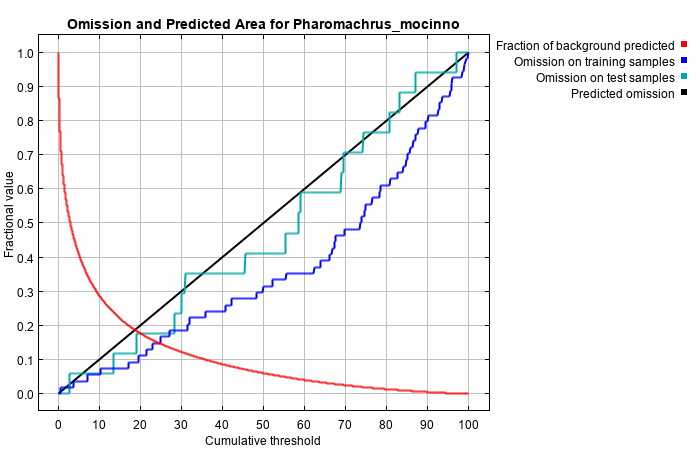

In [16]:
Image(data= data_dir+'result_maxent/plots/Pharomachrus_mocinno_omission.png', width=500, height=500)

En el gráfico se puede apreciar que la omisión en las muestras de prueba concuerda muy bien con la tasa de omisión prevista, la cual corresponde a una línea recta, por definición del formato de salida acumulativo. En algunas situaciones, la línea de omisión de la prueba se encuentra muy por debajo de la línea de omisión predicha: una razón común es que los datos de prueba y entrenamiento no son independientes, por ejemplo, si derivan de los mismos datos de presencia autocorrelacionados espacialmente.

El siguiente gráfico muestra la curva de funcionamiento del receptor para los datos de entrenamiento y de prueba, que se muestran a continuación. El área bajo la curva ROC (AUC) también se da aquí.

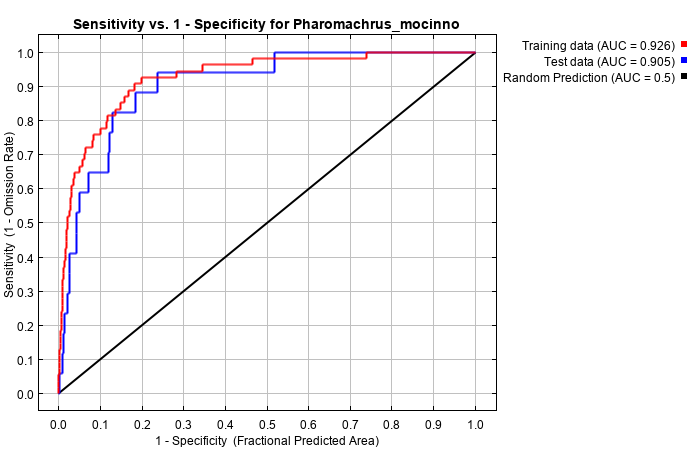

In [17]:
Image(data= data_dir+'result_maxent/plots/Pharomachrus_mocinno_roc.png', width=500, height=500)

Al usar los mismos datos para el entrenamiento y para las pruebas, las líneas roja y azul son casi idénticas. La línea roja (entrenamiento) muestra el "ajuste" del modelo a los datos de entrenamiento. La línea azul (prueba) indica el ajuste del modelo a los datos de prueba y es la prueba real del poder predictivo del modelo. La línea turquesa muestra la línea que se esperaría si el modelo no fuera mejor que el aleatorio. Si la línea azul (la línea de prueba) cae por debajo de la línea turquesa, esto indica que el modelo funciona peor que un modelo aleatorio. Cuanto más hacia la parte superior izquierda del gráfico esté la línea azul, mejor será el modelo para predecir las presencias contenidas en la muestra de prueba de los datos. 

Desde el punto de vista de la representación espacial, se obtiene el mapa que se muestra a continuación:

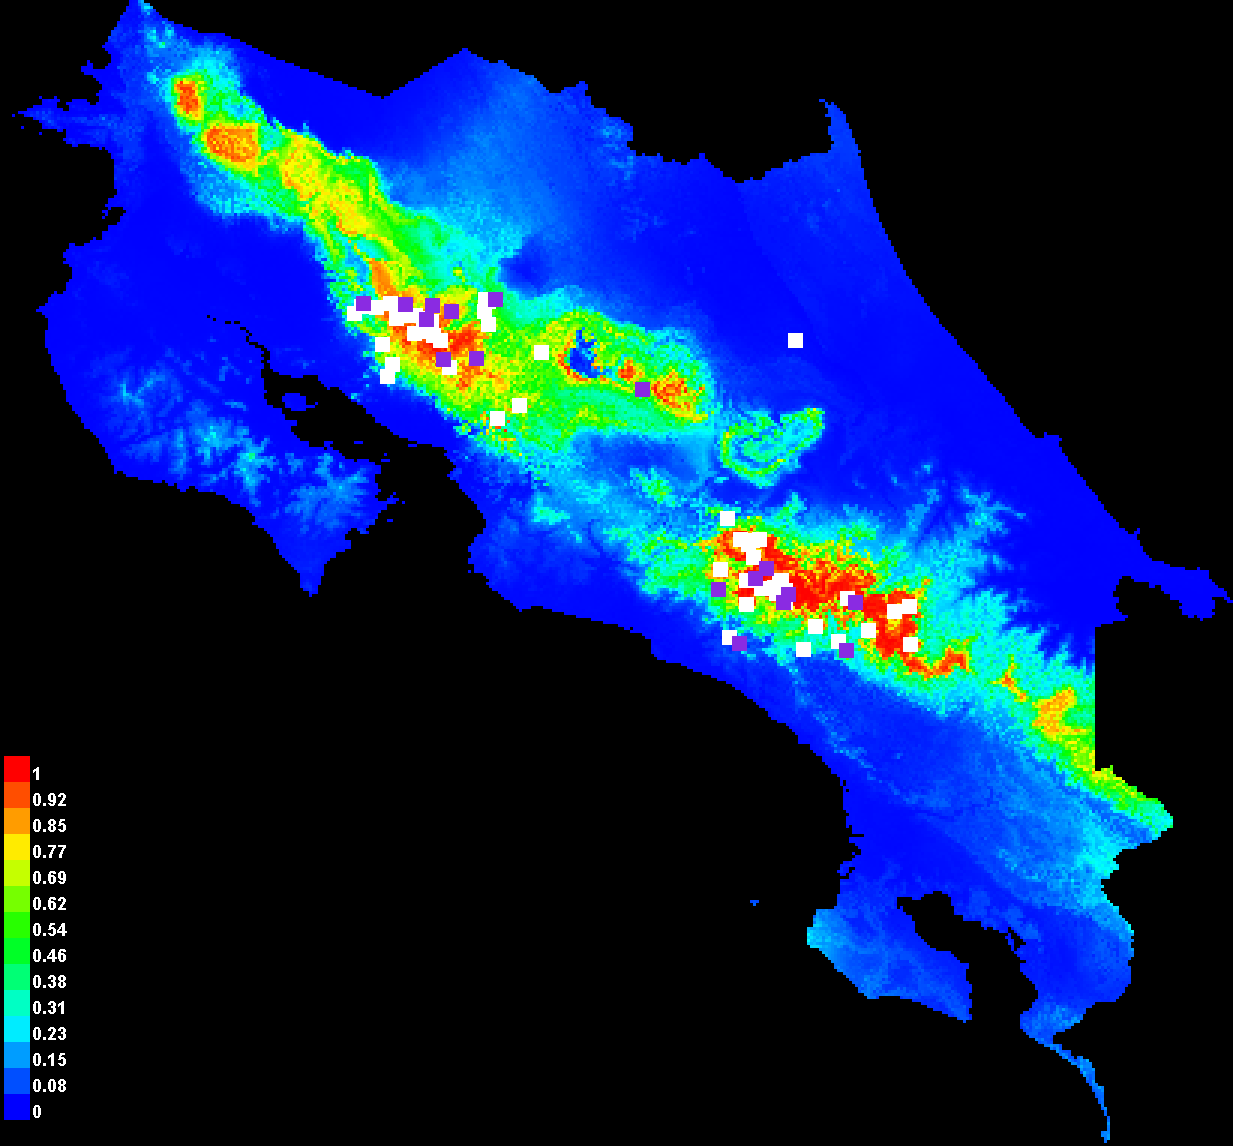

In [18]:
Image(data= data_dir+'result_maxent/plots/Pharomachrus_mocinno.png', width=500, height=500)

La leyenda del mapa muestra una clasificación de valores que oscilan en un rango entre 0 y 1, siendo 0 en este caso una presencia nula de la especie y 1 la mayor probabilidad de presencia de la especie por nicho ecológico según las características bioclimaticas de área correspondiente.

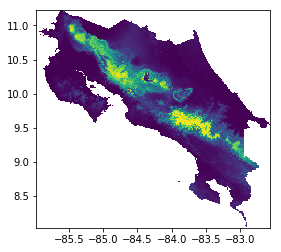

In [19]:
fp = os.path.join(data_dir+'result_maxent/', "Pharomachrus_mocinno.asc")
raster = rasterio.open(fp)
show(raster)

El anterior mapa corresponde al archivo en formato raster resultado del análisis con el maxent. De este archivo se pueden conocer algunas de las siguientes caracteristicas:

In [20]:
raster.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 411,
 'height': 382,
 'count': 1,
 'crs': None,
 'transform': Affine(0.00833333, 0.0, -85.979072453958,
        0.0, -0.00833333, 11.219773428777)}

In [21]:
raster.bounds

BoundingBox(left=-85.979072453958, bottom=8.036441368777, right=-82.55407382395799, top=11.219773428777)

Al ser este un raster de formato ".asc", este se trata básicamentede unas pocas líneas de datos de encabezado seguidas de listas de valores de celda. Los datos del encabezado incluyen las siguientes palabras clave y valores:

ncols: número de columnas en el conjunto de datos.
nrows: número de filas del conjunto de datos.
xllcenter o xllcorner: coordenada x del centro o esquina inferior izquierda de la celda inferior izquierda.
yllcenter o yllcorner: coordenada y del centro o esquina inferior izquierda de la celda inferior izquierda.
tamaño de celda: tamaño de celda para el conjunto de datos.
nodata_value: valor en el archivo asignado a las celdas cuyo valor se desconoce. El valor predeterminado de nodata_value es -9999. A continuación, una muestra de los datos contenidos dentro de este tipo de archivo:

In [22]:
header_rows = 6 
header = {}
row_ite = 1
with open(fp, 'rt') as file_h:
     for line in file_h:
        if row_ite <= header_rows:
             line = line.split(" ", 1)
             header[line[0]] = float(line[1])
        else:
             break
        row_ite = row_ite+1

raster_array = np.loadtxt(fp, skiprows=header_rows, dtype='float64')
raster_array

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

# Análisis de los resultados visibles en el mapa

Como parte de la discusion de resultados, desde el punto de vista espacial de nicho ecológico, se presenta a continuación, un mapa dinámico en el que se configuran ciertos parámetros y se adición mapas base esto con el fin de apoyar, de una mejor manera, el análisis de los resultados.

In [23]:
latitudes = list(df.decimalLatitude)
longitudes = list(df.decimalLongitude)
labels = list(df.species)

attr = ('Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
'contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map '
'style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a>'
' (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)')
tiles = 'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png'

attr2 = ('Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ,'
         'UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC')
tiles2 = 'https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}' 

m = folium.Map(location=[9.5, -83.5], tiles='Cartodb Positron',
                   zoom_start=8, control_scale=True)

L1 = folium.FeatureGroup("Quetzales")
for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='red', icon='leaf')
     ).add_to(L1)     
L1.add_to(m)

L2 = folium.FeatureGroup("MaxEnt")
folium.raster_layers.ImageOverlay(
    image=raster_array,
    bounds=[[8.036441368777, -85.979072453958], [11.219773428777, -82.55407382395799]],
    opacity=0.6,
    zindex=1,
    colormap=cm.viridis,
).add_to(L2)
L2.add_to(m)

folium.TileLayer(tiles, name = 'OpenTopoMap', attr = attr).add_to(m)
folium.TileLayer(tiles2, name = 'ESRI NatGeo', attr = attr2).add_to(m)

colormap = cm2.linear.viridis.scale(0, 1)
colormap.caption = 'Mayor presencia en valores cercanos a 1'
m.add_child(colormap)

Fullscreen().add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m

Según el mapa generado podemos observar que los quetzales se ubican en zonas con clima templado y en altitudes que sobrepasan los 1500msnm. 

Al observar la distribución de los registros de ocurrencia es posible identificar un patron de aglomeración en dos sectores principalmente, los cuales corresponden con la zona del Cerro de la Muerte y la Cordillera Volcanica Central. 

Elizondo(2013) menciona lo siguiente:
>Es una especie residente relativamente común en las montañas cubiertas total o parcialmente de bosque de la Cordillera de Tilarán, y hacia el sur hasta Panamá. En la Cordillera de Tilarán se localiza desde los 1.200 m. en adelante y desde los 1.500 m. hasta alturas mayores a los 3.000 m. en las Cordilleras Volcánica Central y de Talamanca. (p. 6)

Retomando lo que menciona este autor, la información obtenida por MaxEnt vendria a apoyar dicha descripción de distribución de la especie dado el hecho de que es evidente en el mapa como los rangos cercanos a 1, en cuyo caso son los que representan probabilidad de presencia de la especie, se visualizan en correlación con dichas áreas. 

La información que aporta el modelado de nichos ecologicos, con base en algoritmos de envoltura climática como lo es el maxent, subyase su importancia en el conocimiento biogeografico sobre la distribución de especies que al final se puede traducir en una variedad de aplicaciones para la ecología y la conservación. 

Por su parte, es importe tener en consideración que entre mayor sea el número disponible de datos sobre ocurrencia, mejores resultados pueden ser logrados con el algoritmo en cuanto a precisión. 

Un hecho relevante es que los resultados de este análisis deben ser estudiandos en conjunto con otros temas complementarios, como lo puede ser la correlación entre los datos de presencia y las zonas de vida de Holdridge para conocer más sobre los habitats de las especies según su distribución o los estudios de Ecología del paisaje para conocer las interacciones entre los aspectos temporales y espaciales del paisaje y sus componentes de flora, fauna y cultura, así como estudios sobre el Indice de Vegetación (NDVI) para conocer el estado de los habitad de las especies, entre otros temas que puedan aportan mayor peso a este análisis.

# Bibliografia

Elizondo, L. H. (2013, 15 noviembre). INBio - Pharomachrus mocinno. CRBio. http://crbio.cr:8080/neoportal-web/species/Pharomachrus%20mocinno

GBIF (2021) Streaming API for XML. URL: https://api.gbif.org/v1/

Philips, S. (2010) A Brief Tutorial on Maxent. Lessons in Conservation. Vol. 3, pp. 108-135. http://ncep.amnh.org/linc/

Vargas, M. (2021) Modelado de Nichos Ecológicos. https://mfvargas.github.io/pres-modelado-nichos/#/ 

WorldClim ( ) Bioclimatic variables. https://www.worldclim.com/bioclim